In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo
from matplotlib import colormaps

In [2]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [3]:
num_particles = 200
# num_turns = 6000
num_turns = 6000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6
num_turns = 1_000_000

In [4]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [5]:
env = line.env
# monitor1 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, n_repetitions=1, repetition_period=10000, particle_id_range=(num_particles-5, num_particles))
# monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor3 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

# env.elements['monitor_qd31110'] = monitor1
# env.elements['monitor_qf31010'] = monitor2
env.elements['monitor_start'] = monitor3
# line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end'), env.place('monitor_start', at=0)])
line.insert([env.place('monitor_start', at=0)])

Slicing line:   0%|          | 0/3848 [00:00<?, ?it/s]

In [6]:
n_r = 20
n_theta = 10
x_normalized, y_normalized, r_xy, theta_xy = xp.generate_2D_polar_grid(
    r_range=(0, 40.), # beam sigmas
    theta_range=(0, np.pi/2),
    nr=n_r, ntheta=n_theta)

delta_init = df_to_delta(5000*sweep_per_turn)#tw.particle_on_co.delta

part = line.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=2e-6, nemitt_y=2e-6, # normalized emittances
    delta=delta_init,
    zeta=np.ones(num_particles) * tw.particle_on_co.zeta)

In [8]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.track(part, num_turns=num_turns, time=True, with_progress=True)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [9]:
dict_monitor={'x' : monitor3.x.tolist(), 'y' : monitor3.y.tolist(), 'px' : monitor3.px.tolist(), 'py' : monitor3.py.tolist(), 'zeta' : monitor3.zeta.tolist(), 'delta' : monitor3.delta.tolist(), 'state': monitor3.state.tolist()}
part.to_json('dynamic_aperture_part.json', indent=4)
import json
with open(f'dynamic_aperture_mon.json', 'w') as fout:
    json.dump(dict_monitor, fout, indent=4)

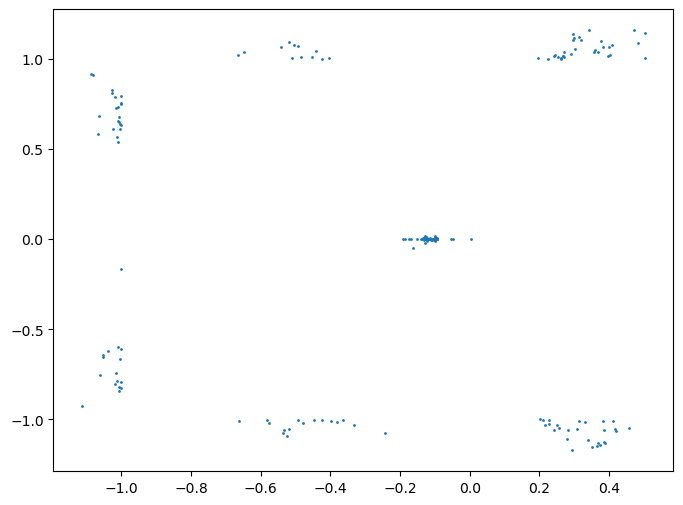

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(part.x, part.y, s=1)

In [11]:
np.unique(part.state, return_counts=True)

(array([-1,  1]), array([124,  76]))

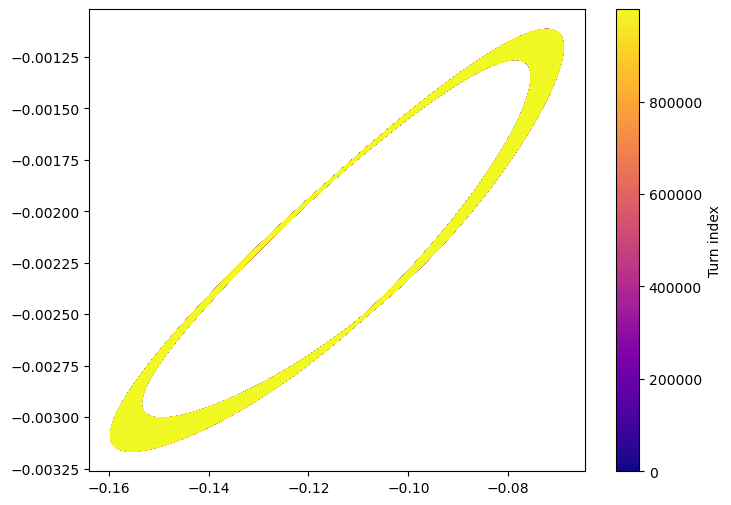

In [35]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
pid = 60
sc = ax.scatter(
    monitor3.x[pid,:], monitor3.px[pid,:],
    c=np.arange(num_turns),
    s=1,
    cmap='plasma',      # or any colormap
    rasterized=True      # optional: makes large scatter MUCH faster in PDFs
)

fig.colorbar(sc, ax=ax, label='Turn index')

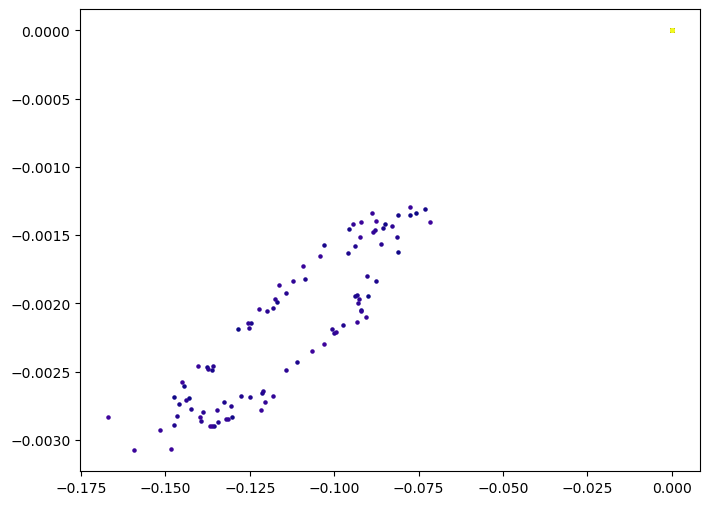

In [32]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
pid = 61
cmap = colormaps['plasma']
for turn in range(0, num_turns, 1000):
    ax.scatter(
        monitor3.x[pid,turn], monitor3.px[pid,turn],
        s=5,
        label=f'Turn {turn}', 
        color = cmap(turn/num_turns)
    )

In [25]:
monitor3.state[-1]

array([1, 1, 1, ..., 0, 0, 0], shape=(1000000,))

In [64]:
len(monitor3.x[pid,:])

1000

In [27]:
np.unique(part.state, return_counts=True)

(array([-1,  1]), array([124,  76]))

In [38]:
dead_pids = part.particle_id[part.state < 1]

In [39]:
dead_pids

array([ 53,  61,  54,  64,  63,  62, 185, 153, 163, 143,  75, 188, 184,
       195,  66, 172, 102, 176, 179, 135, 186, 118, 156, 166,  73,  92,
        95,  78, 155,  89,  76, 174, 173, 124, 136, 111, 126, 128, 154,
       171, 152, 131, 164, 127, 149, 101, 139, 169, 123, 133, 115, 142,
       106, 191, 105, 103,  91, 121, 165,  82, 125, 104, 194, 138, 107,
        88,  83, 144, 197, 132, 122, 113, 146, 145, 161, 112, 129, 108,
        98,  71,  65, 159, 148, 147, 114, 117, 177,  97,  85,  77, 178,
       182, 162, 158, 199, 116, 189,  99,  87, 198, 193,  94,  74,  72,
        79, 181, 157, 167, 151, 134, 137, 141, 119, 109,  93,  96,  81,
        86, 187,  84, 196, 183, 192, 168])

In [36]:
part.at_turn[dead_pids]

array([1000000, 1000000, 1000000, 1000000, 1000000, 1000000,     149,
           493,     384,     548, 1000000,     193,     163,     192,
       1000000,     228,    1205,     285,     249,     647,     166,
           913,     416,     330, 1000000,    1840,    1676,   57272,
           415,    2094,  514707,     264,     252,     875,     580,
          1055,     778,     760,     412,     210,     490,     730,
           316,     712,     444,    1277,     562,     238,     857,
           635,    1083,     523,    1225,     181,    1261,    1225,
          1999,     877,     324,    8848,     755,    1238,     177,
           572,    1189,    2159,    3646,     501,      72,     730,
           885,    1096,     441,     478,     376,    1063,     770,
          1191,    1408, 1000000, 1000000,     331,     497,     421,
          1061,     933,     294,    1482,    3156,   94174,     213,
           117,     377,     330,      61,     937,     196,    1357,
          2452,     

In [41]:
part.state[168]

np.int64(-1)

In [42]:
part.state < 1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [47]:
part.particle_id

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52, 190, 100,  55,  56,  57,  58,  59,  60, 120,  69, 175, 150,
       130,  90,  67,  68, 160,  70, 110,  80, 140, 180, 170,  53,  61,
        54,  64,  63,  62, 185, 153, 163, 143,  75, 188, 184, 195,  66,
       172, 102, 176, 179, 135, 186, 118, 156, 166,  73,  92,  95,  78,
       155,  89,  76, 174, 173, 124, 136, 111, 126, 128, 154, 171, 152,
       131, 164, 127, 149, 101, 139, 169, 123, 133, 115, 142, 106, 191,
       105, 103,  91, 121, 165,  82, 125, 104, 194, 138, 107,  88,  83,
       144, 197, 132, 122, 113, 146, 145, 161, 112, 129, 108,  98,  71,
        65, 159, 148, 147, 114, 117, 177,  97,  85,  77, 178, 182, 162,
       158, 199, 116, 189,  99,  87, 198, 193,  94,  74,  72,  7

In [44]:
np.where(part.particle_id==53)

(array([76]),)

In [46]:
part.state[76]

np.int64(-1)

In [49]:
part2 = part.copy()
part2.sort(interleave_lost_particles=True)

In [51]:
part_init = line.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=2e-6, nemitt_y=2e-6, # normalized emittances
    delta=delta_init,
    zeta=np.ones(num_particles) * tw.particle_on_co.zeta)

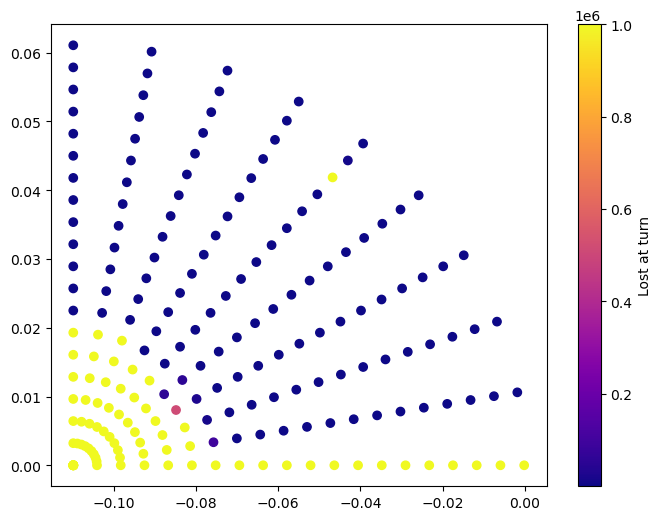

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sc = ax.scatter(part_init.x, part_init.y, c = part2.at_turn, cmap='plasma')
fig.colorbar(sc, ax=ax, label='Lost at turn')

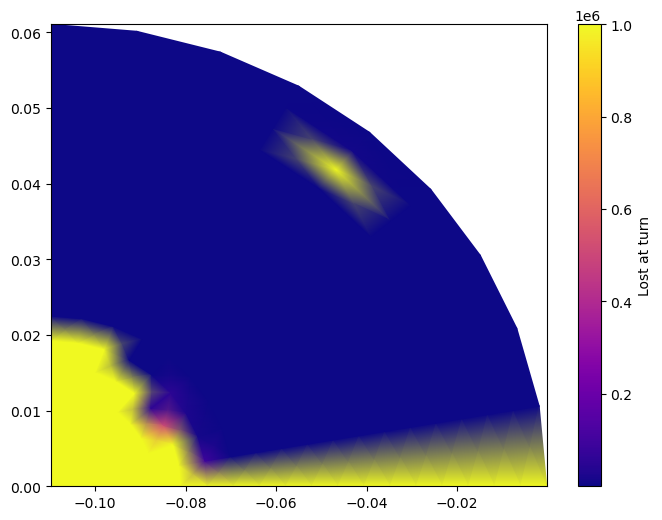

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# alive_pids = part.particle_id[part.state == 1]
sc = ax.pcolormesh(part_init.x.reshape(n_r,n_theta), part_init.y.reshape(n_r,n_theta), part2.at_turn.reshape(n_r,n_theta), shading='gouraud', cmap='plasma')
fig.colorbar(sc, ax=ax, label='Lost at turn')

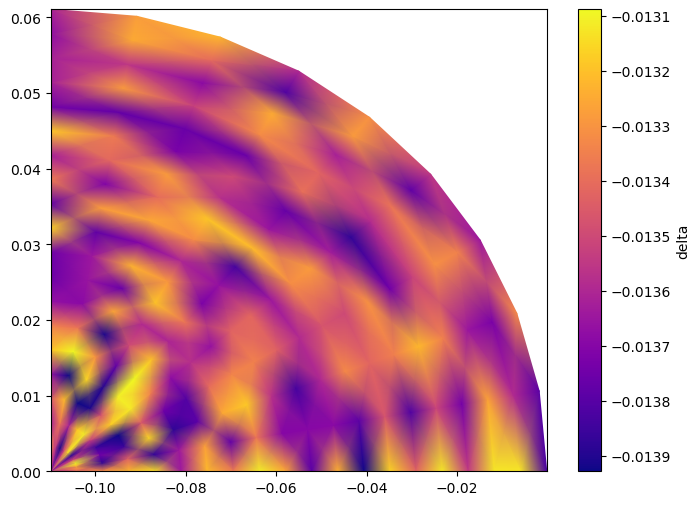

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# alive_pids = part.particle_id[part.state == 1]
sc = ax.pcolormesh(part_init.x.reshape(n_r,n_theta), part_init.y.reshape(n_r,n_theta), part2.delta.reshape(n_r,n_theta), shading='gouraud', cmap='plasma')
fig.colorbar(sc, ax=ax, label='delta')

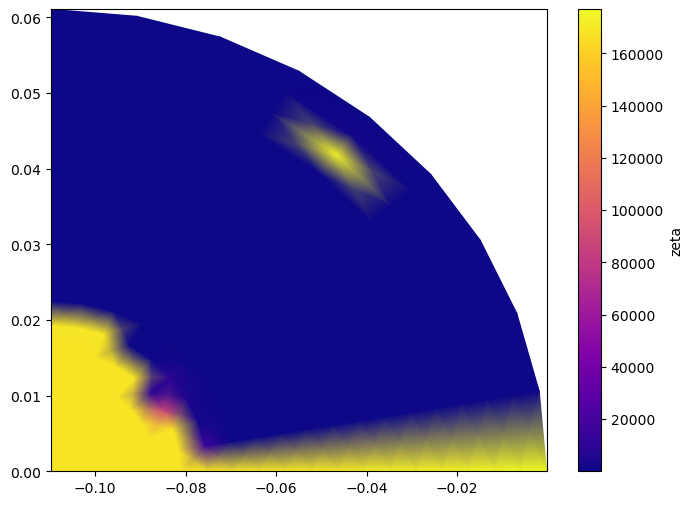

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# alive_pids = part.particle_id[part.state == 1]
sc = ax.pcolormesh(part_init.x.reshape(n_r,n_theta), part_init.y.reshape(n_r,n_theta), part2.zeta.reshape(n_r,n_theta), shading='gouraud', cmap='plasma')
fig.colorbar(sc, ax=ax, label='zeta')

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(monitor3.zeta, monitor3.delta, c=monitor3.at_turn, cmap='plasma')

Error in callback <function _draw_all_if_interactive at 0x12329ed40> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x33c7228e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [60]:
dead_pids = part.particle_id[part.state < 1]
dead_idxs = np.array([np.where(part.particle_id==pid)[0][0] for pid in dead_pids])

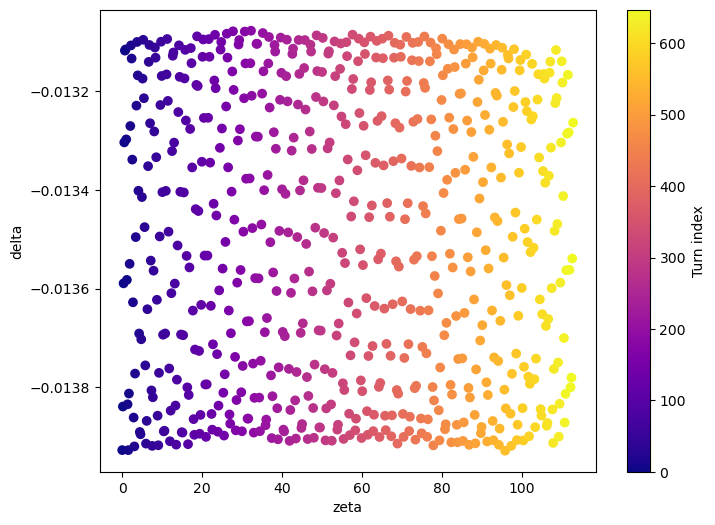

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

nb = 6
sc = ax.scatter(np.trim_zeros(monitor3.zeta[dead_idxs[nb]]), np.trim_zeros(monitor3.delta[dead_idxs[nb]]), c=monitor3.at_turn[dead_idxs[nb], :len(np.trim_zeros(monitor3.zeta[dead_idxs[nb]]))], cmap='plasma')
ax.set_xlabel('zeta')
ax.set_ylabel('delta')
fig.colorbar(sc, ax=ax, label='Turn index')

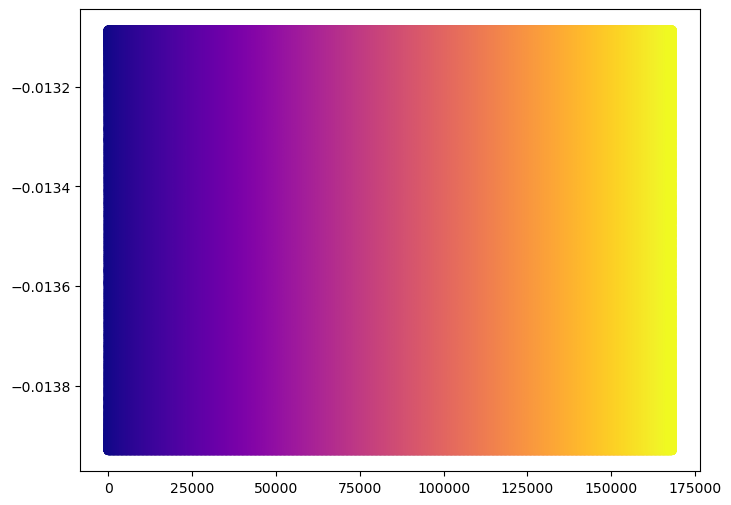

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

nb = 6
ax.scatter(monitor3.zeta[nb, :], monitor3.delta[nb, :], c=monitor3.at_turn[nb, :], cmap='plasma')

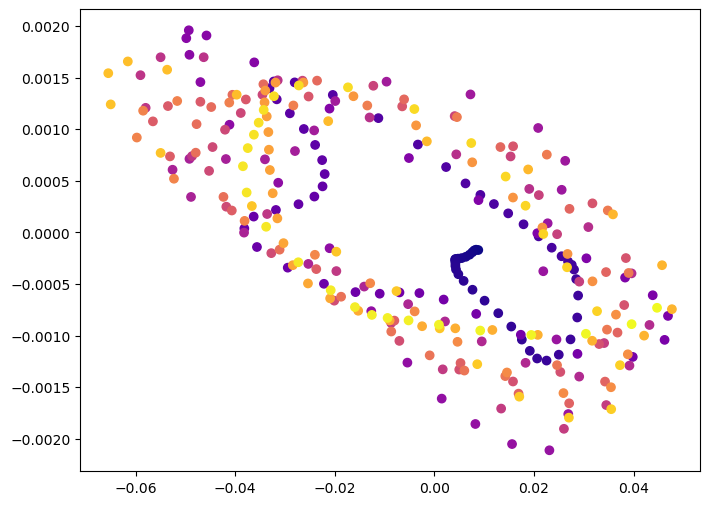

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

nb = 6
max_turn = 300
ax.scatter(monitor3.y[dead_idxs[nb], :max_turn], monitor3.py[dead_idxs[nb], :max_turn], c=monitor3.at_turn[dead_idxs[nb], :max_turn], cmap='plasma')

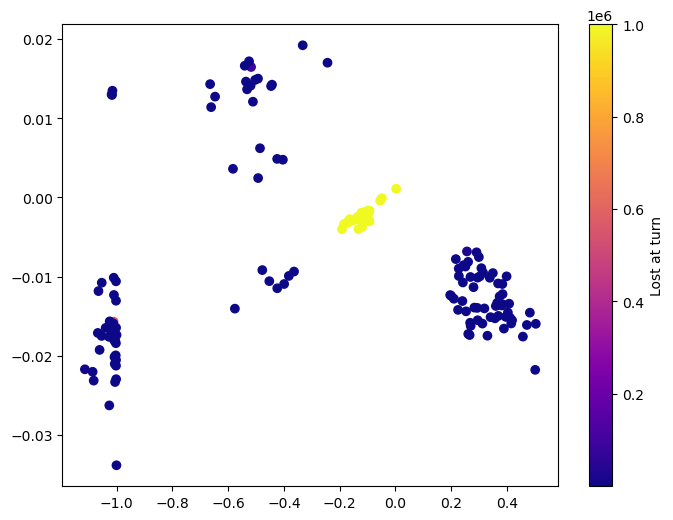

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sc = ax.scatter(part2.x, part2.px, c = part2.at_turn, cmap='plasma')
fig.colorbar(sc, ax=ax, label='Lost at turn')

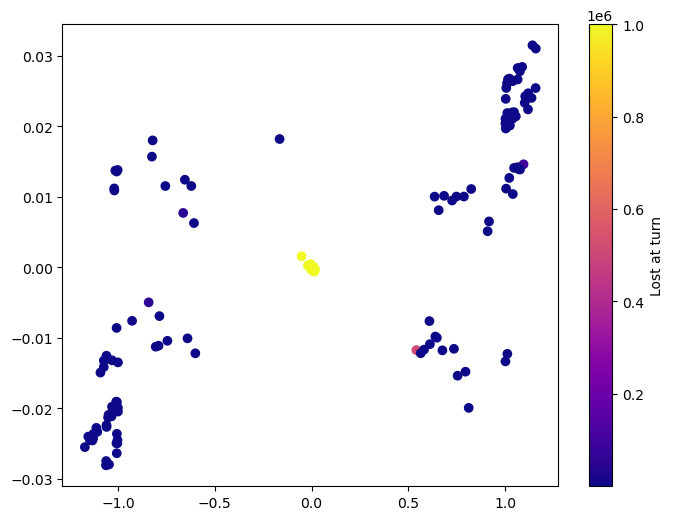

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sc = ax.scatter(part2.y, part2.py, c = part2.at_turn, cmap='plasma')
fig.colorbar(sc, ax=ax, label='Lost at turn')

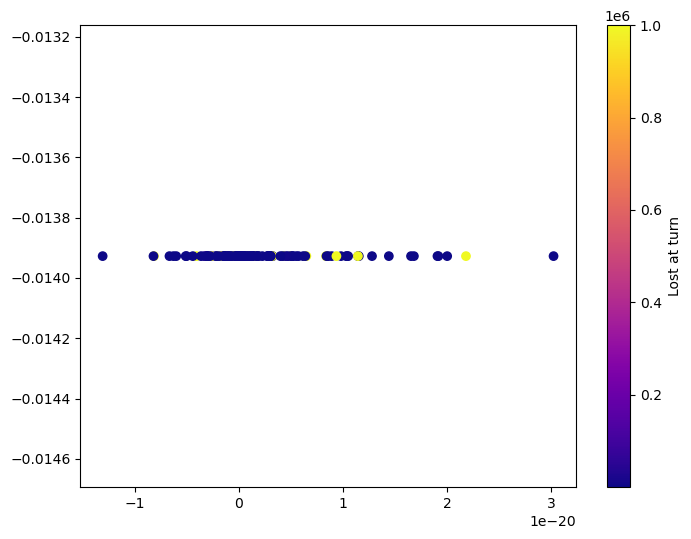

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sc = ax.scatter(part_init.zeta, part_init.delta, c = part2.at_turn, cmap='plasma')
fig.colorbar(sc, ax=ax, label='Lost at turn')